# AutoML - H2O

## ***Environment preparation***

In [1]:
!pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpui75tyy_
  JVM stdout: /tmp/tmpui75tyy_/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpui75tyy_/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_unknownUser_1eenwj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [3]:
import pandas as pd
import random
from PIL import Image

from statsmodels.stats.outliers_influence import variance_inflation_factor

import numpy as np
import matplotlib.pyplot as plt
import plotly.offline as pyo
import plotly.express as px
import seaborn as sns

## ***Binary Classification***

Data source: https://www.kaggle.com/competitions/spaceship-titanic

Cited from: https://github.com/aiskunks/Skunks_Skool/blob/main/H2O_AutoML_IPYNB/automl_binary_classification_product_backorders.ipynb

### Data preparation

In [4]:
# Import data and seperate into "train" and "test"
data = h2o.import_file("/content/data/Binary_Classificaton/space_titanic.csv")
data.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39,False,0,0,0,0,0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24,False,109,9,25,549,44,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58,True,43,3576,0,6715,49,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33,False,0,1283,371,3329,193,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16,False,303,70,151,565,2,Willy Santantines,True
0005_01,Earth,False,F/0/P,PSO J318.5-22,44,False,0,483,0,291,0,Sandie Hinetthews,True
0006_01,Earth,False,F/2/S,TRAPPIST-1e,26,False,42,1539,3,0,0,Billex Jacostaffey,True
0006_02,Earth,True,G/0/S,TRAPPIST-1e,28,False,0,0,0,0,nan,Candra Jacostaffey,True
0007_01,Earth,False,F/3/S,TRAPPIST-1e,35,False,0,785,17,216,0,Andona Beston,True
0008_01,Europa,True,B/1/P,55 Cancri e,14,False,0,0,0,0,0,Erraiam Flatic,True


In [5]:
train, test = data.split_frame(seed = 1234, destination_frames = ["train.hex", "test.hex"])

#### *1. Train Data:*

In [6]:
train.describe()

Rows:6530
Cols:14

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
type,string,enum,enum,enum,enum,int,enum,int,int,int,int,int,string,enum
mins,NaN,,,,,0.0,,0.0,0.0,0.0,0.0,0.0,NaN,
mean,NaN,,,,,28.78317961544474,,221.6336200156372,464.7728765837637,172.33129315756435,327.17843167944915,293.6020376175548,NaN,
maxs,NaN,,,,,79.0,,8586.0,27723.0,23492.0,16594.0,24133.0,NaN,
sigma,NaN,,,,,14.404492722373211,,647.0174821712108,1614.758857846929,609.3331690844501,1168.4761264734366,1109.7151678049174,NaN,
zeros,0,,,,,133,,4216,4106,4209,4007,4136,0,
missing,0,145,146,150,138,133,154,135,137,158,141,150,153,0
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


*We can know that the reponse column, "**Transported**", is already encoded as "enum", so there's nothing we need to preprocess here.*

#### *2. Test Data*

In [7]:
test.describe()

Rows:2163
Cols:14

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
type,string,enum,enum,enum,enum,int,enum,int,int,int,int,int,string,enum
mins,NaN,,,,,0.0,,0.0,0.0,0.0,0.0,0.0,NaN,
mean,NaN,,,,,28.963155408597068,,233.91308455361354,437.85734529995267,177.94462849029813,262.8231966053749,338.6395294117647,NaN,
maxs,NaN,,,,,78.0,,14327.0,29813.0,10424.0,22408.0,17306.0,NaN,
sigma,NaN,,,,,14.744117505051781,,723.0589621624891,1601.7850089789627,590.6154999723123,1033.8858205586482,1247.2496042384012,NaN,
zeros,0,,,,,45,,1361,1350,1378,1317,1359,0,
missing,0,56,71,49,44,46,49,46,46,50,42,38,47,0
0,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
1,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True
2,0011_01,Earth,False,F/2/P,TRAPPIST-1e,28.0,False,8.0,974.0,12.0,2.0,7.0,Elle Bertsontry,True


### *Identify Predictor and Response columns*

*In data "train", I identify the response and predictor columns by saving them as "X" and "Y". Column "Transported" is identified as response factor "Y" and other columns in "train" are indentified as predictors "X".*

In [8]:
# Identify predictors and response
X = train.columns
Y = "Transported"
X.remove(Y)

# For binary classification, response should be a factor
train[Y] = train[Y].asfactor()
test[Y] = test[Y].asfactor()

### Run AutoML

*Run AutoML, stopping after 10 models. The max_models argument specifies the number of individual (or "base") models, and does not include the two ensemble models that are trained at the end.*

In [9]:
# Run AutoML for 10 base models
aml = H2OAutoML(max_models = 10, seed = 1)
aml.train(x = X, y = Y, training_frame = train)

AutoML progress: |
05:58:31.278: _train param, Dropping bad and constant columns: [PassengerId, Name]

██
05:58:43.58: _train param, Dropping bad and constant columns: [PassengerId, Name]

██
05:58:53.908: _train param, Dropping bad and constant columns: [PassengerId, Name]

█
05:59:04.962: _train param, Dropping bad and constant columns: [PassengerId, Name]


05:59:10.277: _train param, Dropping bad and constant columns: [PassengerId, Name]

███
05:59:23.942: _train param, Dropping bad and constant columns: [PassengerId, Name]


05:59:32.393: _train param, Dropping bad and constant columns: [PassengerId, Name]

█
05:59:37.704: _train param, Dropping bad and constant columns: [PassengerId, Name]

█
05:59:43.216: _train param, Dropping bad and constant columns: [PassengerId, Name]

█
05:59:46.425: _train param, Dropping bad and constant columns: [PassengerId, Name]

███
06:00:01.105: _train param, Dropping unused columns: [PassengerId, Name]

███
06:00:09.390: _train param, Dropping unu

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_1_20221108_55831

No summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0674870743562201
RMSE: 0.25978274453131045
LogLoss: 0.2386269320211647
AUC: 0.9792629089620036
AUCPR: 0.9822682082475759
Gini: 0.9585258179240073
Null degrees of freedom: 6529
Residual degrees of freedom: 6522
Null deviance: 9049.147526400931
Residual deviance: 3116.467732196411
AIC: 3132.467732196411

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5294442113037031
       False    True    Error    Rate
-----  -------  ------  -------  --------------
False  3061     130     0.0407   (130.0/3191.0)
True   332      3007    0.0994   (332.0/3339.0)
Total  3393     3137    0.0708   (462.0/6530.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.529444     0.92866   182
max f2                       0.2312       0.936861  285
max f0point5                 0.603759     0.956122  160
max accuracy                 0.529444     0.92925   182
max precision                0.999295     1         0
max recall                   0.129002     1         329
max specificity              0.999295     1         0
max absolute_mcc             0.529444     0.86027   182
max min_per_class_accuracy   0.478049     0.920335  199
max mean_per_class_accuracy  0.529444     0.929915  182
max tns                      0.999295     3191      0
max fns                      0.999295     3056      0
max fps                      0.000361438  3191      399
max tps                      0.129002     3339      329
max tnr                      0.999295     1         0
max fnr                      0.999295     0.915244  0
max fpr                      0.000361438  1         399
max tpr                      0.129002     1         329

Gains/Lift Table: Avg response rate: 51.13 %, avg score: 51.07 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0101072                   0.999369           1.95568    1.95568            1                0.999404   1                           0.999404            0.0197664       0.0197664                  95.5675   95.5675            0.0197664
2        0.0200613                   0.999347           1.95568    1.95568            1                0.999359   1                           0.999382            0.0194669       0.0392333                  95.5675   95.5675            0.0392333
3        0.0300153                   0.999244           1.95568    1.95568            1                0.999316   1                           0.99936             0.0194669       0.0587002                  95.5675   95.5675            0.0587002
4        0.0401225                   0.999133           1.95568    1.95568            1                0.999189   1                           0.999317            0.0197664       0.0784666                  95.5675   95.5675            0.0784666
5        0.0500766                   0.998432           1.95568    1.95568            1                0.998777   1                           0.999209            0.0194669       0.0979335                  95.5675   95.5675            0.0979335
6        0.1                         0.994216           1.95568    1.95568            1                0.995911   1                           0.997563            0.097634        0.

### Model Leaderboard Review

In [10]:
lb = aml.leaderboard
lb.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20221108_55831,0.888443,0.412974,0.90172,0.201675,0.367576,0.135112
StackedEnsemble_BestOfFamily_1_AutoML_1_20221108_55831,0.886958,0.41565,0.899936,0.202146,0.368872,0.136067
GBM_2_AutoML_1_20221108_55831,0.884552,0.429905,0.898373,0.206021,0.374013,0.139885
GBM_3_AutoML_1_20221108_55831,0.883596,0.432934,0.897121,0.205015,0.374895,0.140546
GBM_1_AutoML_1_20221108_55831,0.883036,0.432003,0.896307,0.209147,0.372787,0.13897
GBM_4_AutoML_1_20221108_55831,0.878502,0.450083,0.890704,0.206558,0.380911,0.145093
XRT_1_AutoML_1_20221108_55831,0.87786,0.442118,0.888474,0.212755,0.377383,0.142418
DRF_1_AutoML_1_20221108_55831,0.876238,0.47808,0.887892,0.207705,0.379887,0.144314
GLM_1_AutoML_1_20221108_55831,0.870631,0.447922,0.881675,0.213528,0.382716,0.146471
XGBoost_3_AutoML_1_20221108_55831,0.870045,0.447189,0.884584,0.221063,0.382235,0.146104


In [11]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = se.metalearner()

metalearner.coef_norm()

{'Intercept': 0.2171801993779379,
 'GBM_2_AutoML_1_20221108_55831': 0.14720050795997486,
 'GBM_3_AutoML_1_20221108_55831': 0.24735518229633927,
 'GBM_1_AutoML_1_20221108_55831': 0.5351442917521573,
 'GBM_4_AutoML_1_20221108_55831': 0.0,
 'XRT_1_AutoML_1_20221108_55831': 0.41393293308122847,
 'DRF_1_AutoML_1_20221108_55831': 0.5835914239367481,
 'GLM_1_AutoML_1_20221108_55831': 0.6439810488702419,
 'XGBoost_3_AutoML_1_20221108_55831': 0.0,
 'XGBoost_1_AutoML_1_20221108_55831': 0.18349939849427002,
 'XGBoost_2_AutoML_1_20221108_55831': 0.0}

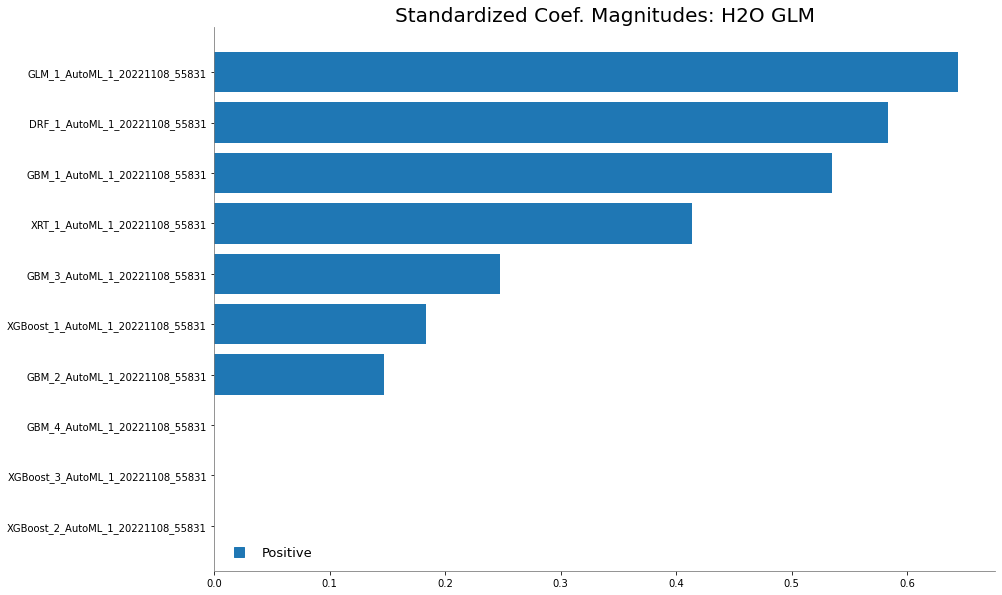

In [12]:
%matplotlib inline
metalearner.std_coef_plot()

### Model Validation

In [14]:
# Showing prediction of the best model in AutoML
best_model = h2o.get_model("GBM_2_AutoML_1_20221108_55831")
performance = best_model.model_performance(test)
performance

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.14453952735744008
RMSE: 0.38018354430122314
LogLoss: 0.44712103045736323
Mean Per-Class Error: 0.20156040745447135
AUC: 0.8783506416996907
AUCPR: 0.8771423971039155
Gini: 0.7567012833993814

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4180164186024089
       False    True    Error    Rate
-----  -------  ------  -------  --------------
False  831      293     0.2607   (293.0/1124.0)
True   148      891     0.1424   (148.0/1039.0)
Total  979      1184    0.2039   (441.0/2163.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.418016     0.801619  224
max f2                       0.16393      0.865064  314
max f0point5                 0.797628     0.805591  93
max accuracy                 0.488722     0.79889   201
max precision                0.982961     1         0
max recall                   0.0310513    1         391
max specificity              0.982961     1         0
max absolute_mcc             0.458893     0.600944  211
max min_per_class_accuracy   0.542226     0.790925  183
max mean_per_class_accuracy  0.487239     0.800126  202
max tns                      0.982961     1124      0
max fns                      0.982961     1031      0
max fps                      0.00870818   1124      399
max tps                      0.0310513    1039      391
max tnr                      0.982961     1         0
max fnr                      0.982961     0.9923    0
max fpr                      0.00870818   1         399
max tpr                      0.0310513    1         391

Gains/Lift Table: Avg response rate: 48.04 %, avg score: 51.60 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0120203                   0.981155           2.08181    2.08181            1                0.981959   1                           0.981959            0.0250241       0.0250241                  108.181   108.181            0.0250241
2        0.0226537                   0.980483           2.08181    2.08181            1                0.980732   1                           0.981383            0.0221367       0.0471607                  108.181   108.181            0.0471607
3        0.0305132                   0.979326           2.08181    2.08181            1                0.979636   1                           0.980933            0.0163619       0.0635226                  108.181   108.181            0.0635226
4        0.0402219                   0.977505           2.08181    2.08181            1                0.978308   1                           0.980299            0.0202117       0.0837344                  108.181   108.181            0.0837344
5        0.050393                    0.975901           2.08181    2.08181            1                0.976561   1                           0.979545            0.0211742       0.104909                   108.181   108.181            0.104909
6        0.100324                    0.969191           2.02398    2.05303            0.972222         0.972709   0.986175                    0.976142            0.101059        0.205967                   102.398   105.303            0.203298
7        0.150717                    0.961404           1.92902    2.01156            0.926606         0.965633   0.966258                    0.972628            0.0972089       0.303176                   92.9016   101.156            

### Questions:

* **Is the relationship significant?**

In [15]:
performance.confusion_matrix()

,False,True,Error,Rate
False,831.0,293.0,0.2607,(293.0/1124.0)
True,148.0,891.0,0.1424,(148.0/1039.0)
Total,979.0,1184.0,0.2039,(441.0/2163.0)


> Accuracy of the prediction in AutoML's best model is about 80%, it means relationships between the independent variables and response variable is significant. 

* **Are any model assumptions violated?**


> I don't have any model assumptions in AutoML for binary classification, so there's no assumption violation.

* **Is there any multicollinearity in the model?**



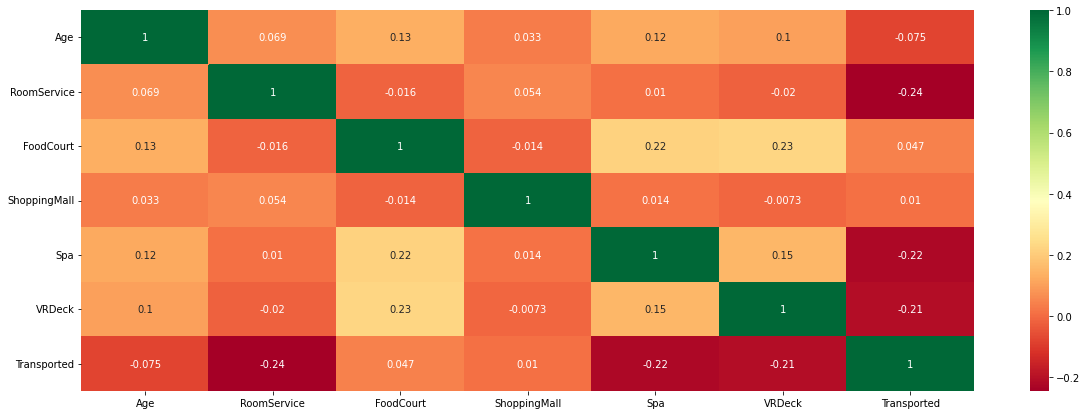

In [16]:
df = pd.read_csv("/content/data/Binary_Classificaton/space_titanic.csv")

plt.figure(figsize=(20,7))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')





> According to the graph above, there is no multicollinearity in each variables.





* **In the multivariate models are predictor variables independent of all the other predictor variables?**









> Yes, all independent variables are indenpendent.



* **In multivariate models, rank the most significant predictor variables and exclude insignificant ones from the model.**

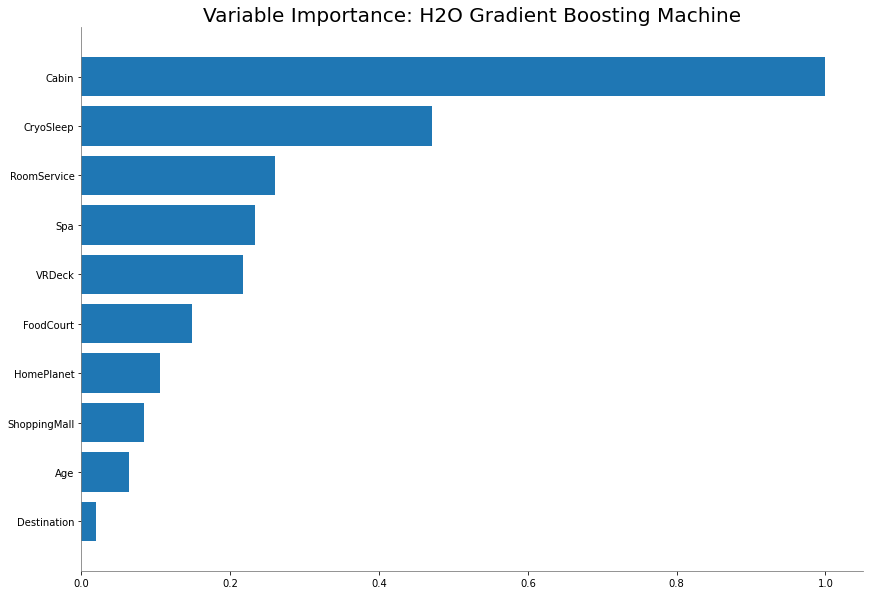

<Figure size 432x288 with 0 Axes>

In [17]:
%matplotlib inline
best_model.varimp_plot()

The most insignificant variable is "Destination", so I remove it and reform AutoML model.

In [18]:
X.remove("Destination")

# Rerun AutoML
aml = H2OAutoML(max_models = 10, seed = 1)
aml.train(x = X, y = Y, training_frame = train)

lb = aml.leaderboard
lb.head()

AutoML progress: |
06:00:55.131: _train param, Dropping bad and constant columns: [PassengerId, Name]

██
06:01:01.887: _train param, Dropping bad and constant columns: [PassengerId, Name]

██
06:01:08.784: _train param, Dropping bad and constant columns: [PassengerId, Name]

█
06:01:14.251: _train param, Dropping bad and constant columns: [PassengerId, Name]


06:01:18.218: _train param, Dropping bad and constant columns: [PassengerId, Name]

██
06:01:25.922: _train param, Dropping bad and constant columns: [PassengerId, Name]

█
06:01:29.788: _train param, Dropping bad and constant columns: [PassengerId, Name]

█
06:01:33.409: _train param, Dropping bad and constant columns: [PassengerId, Name]

██
06:01:38.758: _train param, Dropping bad and constant columns: [PassengerId, Name]


06:01:42.177: _train param, Dropping bad and constant columns: [PassengerId, Name]

███
06:01:57.732: _train param, Dropping unused columns: [PassengerId, Name]

███
06:02:04.335: _train param, Dropping un

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_2_20221108_60055,0.886281,0.416843,0.898893,0.198017,0.369197,0.136307
StackedEnsemble_BestOfFamily_1_AutoML_2_20221108_60055,0.885324,0.418809,0.898469,0.20036,0.370043,0.136932
GBM_2_AutoML_2_20221108_60055,0.882637,0.433061,0.897182,0.209948,0.375416,0.140938
GBM_1_AutoML_2_20221108_60055,0.88184,0.434319,0.894773,0.200555,0.373983,0.139863
GBM_3_AutoML_2_20221108_60055,0.880929,0.439656,0.894837,0.207411,0.377995,0.14288
GBM_4_AutoML_2_20221108_60055,0.879317,0.447627,0.891776,0.205081,0.379679,0.144156
XRT_1_AutoML_2_20221108_60055,0.876096,0.459512,0.888672,0.208682,0.379107,0.143722
DRF_1_AutoML_2_20221108_60055,0.873762,0.536355,0.884007,0.211022,0.383885,0.147368
XGBoost_3_AutoML_2_20221108_60055,0.870636,0.446575,0.882334,0.216837,0.381672,0.145673
GLM_1_AutoML_2_20221108_60055,0.869962,0.449192,0.878509,0.213037,0.38311,0.146773


In [19]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = se.metalearner()

metalearner.coef_norm()

{'Intercept': 0.20637296209133588,
 'GBM_2_AutoML_2_20221108_60055': 0.45234240256637637,
 'GBM_1_AutoML_2_20221108_60055': 0.4437975062677573,
 'GBM_3_AutoML_2_20221108_60055': 0.0,
 'GBM_4_AutoML_2_20221108_60055': 0.07851827555446537,
 'XRT_1_AutoML_2_20221108_60055': 0.17934292426517223,
 'DRF_1_AutoML_2_20221108_60055': 0.5795420895452476,
 'XGBoost_3_AutoML_2_20221108_60055': 0.0,
 'GLM_1_AutoML_2_20221108_60055': 0.6221426868556177,
 'XGBoost_1_AutoML_2_20221108_60055': 0.287154929172388,
 'XGBoost_2_AutoML_2_20221108_60055': 0.0}

In [21]:
# Showing prediction of the best model in AutoML
best_model = h2o.get_model("GBM_2_AutoML_2_20221108_60055")
performance = best_model.model_performance(test)
performance.confusion_matrix()

,False,True,Error,Rate
False,811.0,313.0,0.2785,(313.0/1124.0)
True,141.0,898.0,0.1357,(141.0/1039.0)
Total,952.0,1211.0,0.2099,(454.0/2163.0)




> The result shows that "Destination" doesn't affect the model.



* **Does the model make sense?**



> According to the result from the model, the chance of passengers been transported or not closely related to their cabin, and this make sense in the real life.



* **Does regularization help?**



> Binary classification doesn't need to use regularization.



* **Which independent variables are significant?**



> Passenger's cabin



* **Which hyperparameters are important?**



> I didn't use any hyperparameters in this binary classification's model learning process.



## ***Linear Regression***

Data Source: https://www.kaggle.com/datasets/andonians/random-linear-regression

Cited from https://github.com/aiskunks/Skunks_Skool/blob/main/H2O_AutoML_IPYNB/automl_regression_powerplant_output.ipynb

### Data preparation

In [22]:
# Import ane seperate data to "train" and "test" datasets
data = h2o.import_file("/content/data/Regression/house_pricing.csv")
data.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:4600
Cols:18

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
type,time,real,int,real,int,int,real,int,int,int,int,int,int,int,string,enum,enum,enum
mins,1398988800000.0,0.0,0.0,0.0,370.0,638.0,1.0,0.0,0.0,1.0,370.0,0.0,1900.0,0.0,NaN,,,
mean,1402110882782.6084,551962.988473214,3.400869565217391,2.1608152173913036,2139.3469565217383,14852.516086956524,1.5120652173913047,0.007173913043478261,0.24065217391304342,3.4517391304347824,1827.2654347826087,312.08152173913044,1970.786304347827,808.608260869565,NaN,,,
maxs,1404950400000.0,26590000.0,9.0,8.0,13540.0,1074218.0,3.5,1.0,4.0,5.0,9410.0,4820.0,2014.0,2014.0,NaN,,,
sigma,1702786492.786825,563834.7025471414,0.9088481155258185,0.7837810746502805,963.2069157608641,35884.43614480965,0.5382883772969886,0.08440377189474321,0.7784047172125207,0.6772297675592749,862.1689769625975,464.1372280666067,29.731848390099614,979.4145364007454,NaN,,,
zeros,0,49,2,2,0,0,0,4567,4140,0,0,2745,0,2735,0,,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,2014-05-02 00:00:00,313000.0,3.0,1.5,1340.0,7912.0,1.5,0.0,0.0,3.0,1340.0,0.0,1955.0,2005.0,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.5,3650.0,9050.0,2.0,0.0,4.0,5.0,3370.0,280.0,1921.0,0.0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.0,1930.0,11947.0,1.0,0.0,0.0,4.0,1930.0,0.0,1966.0,0.0,26206-26214 143rd Ave SE,Kent,WA 98042,USA


In this dataset, I will use "price" as response and drop other unrelative columns like "date", "street", and "country".

In [23]:
# Data clearance
data = data.drop("date")
data = data.drop("street")
data = data.drop("country")
data

price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,statezip
313000,3,1.5,1340,7912,1.5,0,0,3,1340,0,1955,2005,Shoreline,WA 98133
2.384e+06,5,2.5,3650,9050,2,0,4,5,3370,280,1921,0,Seattle,WA 98119
342000,3,2,1930,11947,1,0,0,4,1930,0,1966,0,Kent,WA 98042
420000,3,2.25,2000,8030,1,0,0,4,1000,1000,1963,0,Bellevue,WA 98008
550000,4,2.5,1940,10500,1,0,0,4,1140,800,1976,1992,Redmond,WA 98052
490000,2,1,880,6380,1,0,0,3,880,0,1938,1994,Seattle,WA 98115
335000,2,2,1350,2560,1,0,0,3,1350,0,1976,0,Redmond,WA 98052
482000,4,2.5,2710,35868,2,0,0,3,2710,0,1989,0,Maple Valley,WA 98038
452500,3,2.5,2430,88426,1,0,0,4,1570,860,1985,0,North Bend,WA 98045
640000,4,2,1520,6200,1.5,0,0,3,1520,0,1945,2010,Seattle,WA 98115


In [24]:
# Cited from https://github.com/aiskunks/Skunks_Skool/blob/main/H2O_AutoML_IPYNB/automl_regression_powerplant_output.ipynb

# Seperate dataset into "train" and "test"
splits = data.split_frame(ratios = [0.8], seed = 1)
train = splits[0]
test = splits[1]

#### *1. Train Data:*

In [25]:
train.describe()

Rows:3695
Cols:15

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,statezip
type,real,int,real,int,int,real,int,int,int,int,int,int,int,enum,enum
mins,0.0,0.0,0.0,370.0,638.0,1.0,0.0,0.0,1.0,370.0,0.0,1900.0,0.0,,
mean,553996.8699343982,3.4037889039242226,2.1609607577807846,2139.916644113667,14788.384303112312,1.5155615696887688,0.006765899864682003,0.2449255751014885,3.4506089309878214,1831.3388362652233,308.57780784844397,1970.9410013531801,805.2909336941814,,
maxs,26590000.0,8.0,8.0,13540.0,1074218.0,3.5,1.0,4.0,5.0,9410.0,4820.0,2014.0,2014.0,,
sigma,595385.5450709338,0.8956894540465254,0.7772666853042698,959.1425962025312,36589.62071299771,0.5415480451981687,0.08198744820440895,0.7824105772930069,0.6773335667655733,858.7375928207035,462.71197731679814,29.813466007136544,978.7607016864488,,
zeros,36,1,1,0,0,0,3670,3317,0,0,2211,0,2203,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,313000.0,3.0,1.5,1340.0,7912.0,1.5,0.0,0.0,3.0,1340.0,0.0,1955.0,2005.0,Shoreline,WA 98133
1,2384000.0,5.0,2.5,3650.0,9050.0,2.0,0.0,4.0,5.0,3370.0,280.0,1921.0,0.0,Seattle,WA 98119
2,420000.0,3.0,2.25,2000.0,8030.0,1.0,0.0,0.0,4.0,1000.0,1000.0,1963.0,0.0,Bellevue,WA 98008


#### *2. **Test** Data:*

In [26]:
test.describe()

Rows:905
Cols:15

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,statezip
type,real,int,real,int,int,real,int,int,int,int,int,int,int,enum,enum
mins,0.0,0.0,0.0,380.0,750.0,1.0,0.0,0.0,1.0,380.0,0.0,1900.0,0.0,,
mean,543658.9089162243,3.388950276243094,2.160220994475138,2137.020994475138,15114.358011049722,1.4977900552486187,0.008839779005524863,0.22320441988950276,3.456353591160221,1810.6342541436463,326.3867403314917,1970.1546961325964,822.1524861878453,,
maxs,7062500.0,9.0,6.25,10040.0,435600.0,3.5,1.0,4.0,5.0,8020.0,2360.0,2014.0,2014.0,,
sigma,410757.8896301813,0.9611303625691193,0.8102755156639057,980.1598933817597,32866.269593275734,0.5248214826184296,0.09365537565634788,0.7620076440154423,0.6771605596219806,876.3234403206638,469.898471712552,29.40415550935619,982.5055151711415,,
zeros,13,1,1,0,0,0,897,823,0,0,534,0,532,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,342000.0,3.0,2.0,1930.0,11947.0,1.0,0.0,0.0,4.0,1930.0,0.0,1966.0,0.0,Kent,WA 98042
1,640000.0,4.0,2.0,1520.0,6200.0,1.5,0.0,0.0,3.0,1520.0,0.0,1945.0,2010.0,Seattle,WA 98115
2,750000.0,3.0,1.75,2240.0,10578.0,2.0,0.0,0.0,5.0,1550.0,690.0,1923.0,0.0,Seattle,WA 98115


### Identify Predictor and Response columns

In this case, "price" is the response variable.

In [27]:
# Identify response
Y = "price"
X = train.columns
X.remove(Y)

### Run AutoML

In [28]:
# Cited from https://github.com/aiskunks/Skunks_Skool/blob/main/H2O_AutoML_IPYNB/automl_regression_powerplant_output.ipynb

aml = H2OAutoML(max_runtime_secs = 60, seed = 1, project_name = "powerplant_lb_frame")
aml.train(y = Y, training_frame = train, leaderboard_frame = test)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_5_AutoML_3_20221108_60239


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    28                 28                          26066                  6            6            6             45            61            55.75

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 27680826180.316315
RMSE: 166375.5576408876
MAE: 78350.42413100474
RMSLE: 1.2889966175708893
Mean Residual Deviance: 27680826180.316315

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 289240322953.64154
RMSE: 537810.6757527611
MAE: 121189.05663097888
RMSLE: NaN
Mean Residual Deviance: 289240322953.64154

Cross-Validation Metrics Summary: 
                        mean        sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ----------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     120202      16639.9     119989        108810        138636        134317        99257.6
mean_residual_deviance  2.9201e+11  3.9492e+11  8.21907e+10   6.62075e+10   9.75086e+11   2.94031e+11   4.25347e+10
mse                     2.9201e+11  3.9492e+11  8.21907e+10   6.62075e+10   9.75086e+11   2.94031e+11   4.25347e+10
r2                      0.352571    0.235932    0.376572      0.564225      0.0449166     0.188521      0.58862
residual_deviance       2.9201e+11  3.9492e+11  8.21907e+10   6.62075e+10   9.75086e+11   2.94031e+11   4.25347e+10
rmse                    455989      324198      286689        257308        987464        542246        206239
rmsle                   1.26117     0.0518302   1.3083        nan           1.26955       nan           1.20566

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2022-11-08 06:03:15  1.221 sec   0                  595305           251839          3.54388e+11
    2022-11-08 06:03:15  1.247 sec   5                  442424           175445          1.95739e+11
    2022-11-08 06:03:15  1.271 sec   10                 324336           130883          1.05194e+11
    2022-11-08 06:03:15  1.294 sec   15                 277466           104754          7.69875e+10
    2022-11-08 06:03:15  1.317 sec   20                 210417           90047           4.42753e+10
    2022-11-08 06:03:15  1.342 sec   25                 187033           82070.7         3.49813e+10
    2022-11-08 06:03:15  1.358 sec   28                 166376           78350.4         2.76808e+10

Variable Importances: 
variable       relative_importance    scaled_importance    percentage
-------------  ---------------------  -------------------  ------------
sqft_living    1.81034e+15            1                    0.287069
statezip       1.31067e+15            0.72399              0.207835
sqft_above     9.43797e+14            0.521336             0.149659
city           7.44638e+14            0.411324             0.118078
bathrooms      4.25405e+14            0.234986             0.0674572
yr_built       2.86844e+14            0.158447             0.0454853
yr_renovated   1.75003e+14            0.0966684            0.0277505
sqft_lot       1.54662e+14            0.0854326            0.0245251
condition      1.52684e+14            0.08434              0.0242114
floors         1.47567e+14            0.0815133            0.0234
view           6.5943e+13             0.0364257            0.0104567
waterfront     3.62297e+13            0.0200126            0.00574501
sqft_bas

### Leaderboard Review

In [29]:
aml.leaderboard.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_5_AutoML_3_20221108_60239,258014,6.65711e+10,113439,nan,6.65711e+10
StackedEnsemble_AllModels_2_AutoML_3_20221108_60239,259014,6.70883e+10,122699,1.64251,6.70883e+10
StackedEnsemble_AllModels_3_AutoML_3_20221108_60239,259116,6.71409e+10,122247,1.64203,6.71409e+10
StackedEnsemble_BestOfFamily_4_AutoML_3_20221108_60239,260785,6.80089e+10,126617,1.64679,6.80089e+10
StackedEnsemble_BestOfFamily_3_AutoML_3_20221108_60239,260896,6.80666e+10,126897,1.64698,6.80666e+10
DeepLearning_1_AutoML_3_20221108_60239,264366,6.98895e+10,138725,1.65034,6.98895e+10
StackedEnsemble_AllModels_1_AutoML_3_20221108_60239,270334,7.30807e+10,119263,1.63474,7.30807e+10
DeepLearning_grid_1_AutoML_3_20221108_60239_model_1,270791,7.3328e+10,127396,1.64261,7.3328e+10
StackedEnsemble_BestOfFamily_2_AutoML_3_20221108_60239,274004,7.5078e+10,121888,1.64028,7.5078e+10
GBM_grid_1_AutoML_3_20221108_60239_model_4,276044,7.62003e+10,125408,1.63391,7.62003e+10


### Model Validation

In [31]:
best_model = h2o.get_model("GBM_5_AutoML_3_20221108_60239")
performance = best_model.model_performance(test)
performance

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 66571124591.660164
RMSE: 258013.80697873546
MAE: 113439.25465314853
RMSLE: NaN
Mean Residual Deviance: 66571124591.660164

### Questions:

* **Is the relationship significant?**

In [32]:
# Get R_square from test's response and prediction from the model
var = test[Y].var(y=None, na_rm=False, use=None)
print(1 - performance.rmse() / var)

0.9999984707759518


> R_square of the test data in AutoML's best model is about 1. It means relationships between the independent variables and response variable is significant. 

* **Are any model assumptions violated?**


> I don't have any model assumptions in AutoML for binary classification, so there's no assumption violation.

* **Is there any multicollinearity in the model?**



In [33]:
cor = test.cor(y=None, na_rm=False, use=None)
cor

price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,statezip
1,0.275098,0.436425,0.651506,0.0634352,0.254923,0.274918,0.321007,0.0691493,0.550074,0.333131,0.00847566,-0.048987,nan,nan
0.275098,1,0.587133,0.609071,0.0434828,0.234163,0.0723625,0.110911,0.00741645,0.502733,0.332904,0.177373,-0.0195238,nan,nan
0.436425,0.587133,1,0.762716,0.0683959,0.500605,0.134374,0.186568,-0.0870366,0.694279,0.296173,0.458839,-0.178098,nan,nan
0.651506,0.609071,0.762716,1,0.174534,0.379233,0.21141,0.276098,-0.0418722,0.877743,0.448976,0.283807,-0.0851195,nan,nan
0.0634352,0.0434828,0.0683959,0.174534,1,-0.030162,0.0308564,0.0155804,-0.0704812,0.187332,0.0147008,0.0627435,-0.0350054,nan,nan
0.254923,0.234163,0.500605,0.379233,-0.030162,1,0.0791669,0.063471,-0.238388,0.551603,-0.237655,0.46291,-0.274096,nan,nan
0.274918,0.0723625,0.134374,0.21141,0.0308564,0.0791669,1,0.42183,-0.0287945,0.178923,0.107303,0.0111519,-0.00685498,nan,nan
0.321007,0.110911,0.186568,0.276098,0.0155804,0.063471,0.42183,1,0.0746391,0.148938,0.298154,-0.043063,0.0112044,nan,nan
0.0691493,0.00741645,-0.0870366,-0.0418722,-0.0704812,-0.238388,-0.0287945,0.0746391,1,-0.154342,0.200495,-0.389553,-0.168458,nan,nan
0.550074,0.502733,0.694279,0.877743,0.187332,0.551603,0.178923,0.148938,-0.154342,1,-0.0340397,0.392338,-0.147818,nan,nan






> According to the table above, the corelation coefficient between each variable is small enough to say that there is no multicollinearity in each variables.





* **In the multivariate models are predictor variables independent of all the other predictor variables?**









> Yes, all independent variables are indenpendent.



* **In multivariate models, rank the most significant predictor variables and exclude insignificant ones from the model.**

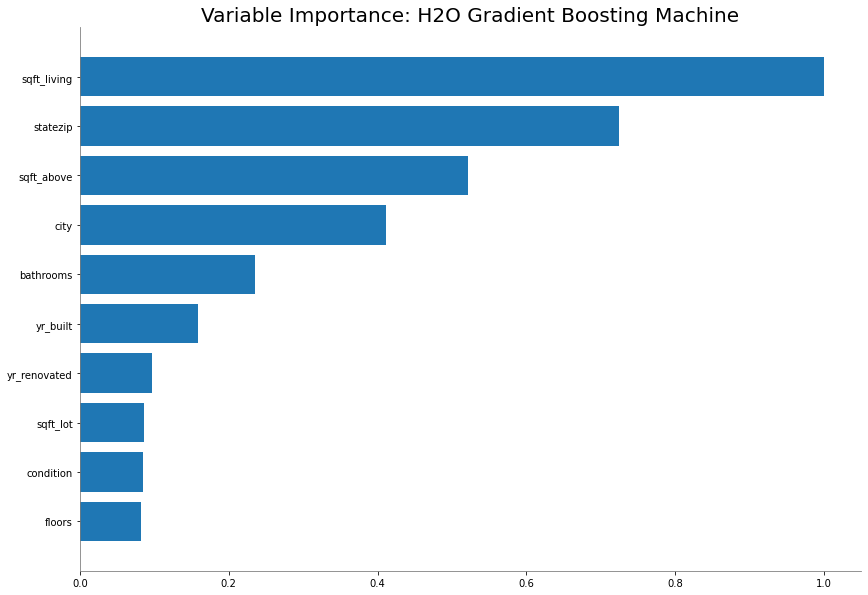

<Figure size 432x288 with 0 Axes>

In [34]:
%matplotlib inline
best_model.varimp_plot()

The most insignificant variable is "floors", so I remove it and reform AutoML model.

In [36]:
X.remove("floors")

# Rerun AutoML
aml = H2OAutoML(max_runtime_secs = 60, seed = 1, project_name = "powerplant_lb_frame")
aml.train(y = Y, training_frame = train, leaderboard_frame = test)

AutoML progress: |
06:04:08.909: New models will be added to existing leaderboard powerplant_lb_frame@@price (leaderboard frame=py_20_sid_8a03) with already 30 models.
06:04:14.720: StackedEnsemble_BestOfFamily_5_AutoML_4_20221108_60408 [StackedEnsemble best_of_family_1 (built with AUTO metalearner, using top model from each algorithm type)] failed: water.exceptions.H2OIllegalArgumentException: Failed to find the xval predictions frame. . .  Looks like keep_cross_validation_predictions wasn't set when building the models, or the frame was deleted.
06:04:28.205: StackedEnsemble_BestOfFamily_6_AutoML_4_20221108_60408 [StackedEnsemble best_of_family_2 (built with AUTO metalearner, using top model from each algorithm type)] failed: water.exceptions.H2OIllegalArgumentException: Failed to find the xval predictions frame. . .  Looks like keep_cross_validation_predictions wasn't set when building the models, or the frame was deleted.
06:04:28.211: StackedEnsemble_AllModels_4_AutoML_4_20221108_

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_2_AutoML_4_20221108_60408


Status of Neuron Layers: predicting price, regression, gaussian distribution, Quadratic loss, 1,591 weights/biases, 27.3 KB, 38,784 training samples, mini-batch size 1
    layer    units    type       dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight             weight_rms           mean_bias            bias_rms
--  -------  -------  ---------  ---------  ----  ----  ---------------------  ---------------------  ----------  ----------------------  -------------------  -------------------  -----------------------
    1        135      Input      0.0
    2        10       Rectifier  0.0        0.0   0.0   0.03770237152817572    0.17905211448669434    0.0         -9.348019326538364e-05  0.12324902415275574  0.5091480488239711   0.09684517979621887
    3        10       Rectifier  0.0        0.0   0.0   0.0012854562466964126  0.0012241802178323269  0.0         0.03678668331354856     0.34147000312805176  1.0162792629191604   0.03330652415752411
    4        10       Rectifier  0.0        0.0   0.0   0.10213184944426758    0.2986030578613281     0.0         -0.05781939442967996    0.2954059839248657   1.007033619876935    0.018266305327415466
    5        1        Linear                0.0   0.0   0.1012516368951765     0.29894375801086426    0.0         0.03701037093997002     0.3865840435028076   0.02191101105954267  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 262870048466.9591
RMSE: 512708.5414413915
MAE: 119207.49030617501
RMSLE: NaN
Mean Residual Deviance: 262870048466.9591

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 266820572426.04572
RMSE: 516546.7766098688
MAE: 120494.87157278876
RMSLE: 1.3478240540595778
Mean Residual Deviance: 266820572426.04572

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     120495       15388.7      109338        107114        140823        133127        112072
mean_residual_deviance  2.66821e+11  4.03886e+11  3.82384e+10   4.1796e+10    9.72328e+11   2.41228e+11   4.05121e+10
mse                     2.66821e+11  4.03886e+11  3.82384e+10   4.1796e+10    9.72328e+11   2.41228e+11   4.05121e+10
r2                      0.48498      0.290414     0.709956      0.7249        0.0476181     0.334246      0.608182
residual_deviance       2.66821e+11  4.03886e+11  3.82384e+10   4.1796e+10    9.72328e+11   2.41228e+11   4.05121e+10
rmse                    415696       342814       195546        204441        986067        491150        201276
rmsle                   1.34279      0.130162     1.31849       1.56025       1.27652       1.34036       1.21831

Scoring History: 
    timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------
    2022-11-08 06:04:38  0.000 sec                     0         0             0          nan              nan                  nan             nan
    2022-11-08 06:04:38  1.324 sec   162333 obs/sec    1.0544    1             3896       533612           2.84742e+11          159159          0.196524
    2022-11-08 06:04:39  1.531 sec   173142 obs/sec    10.4963   10            38784      512709           2.6287e+11           119207          0.258242

Variable Importances: 
variable              relative_importance    scaled_importance    percentage
--------------------  ---------------------  -------------------  ---------------------
state

In [37]:
# Showing prediction of the best model in AutoML
best_model = aml.leader
performance = best_model.model_performance(test)
performance

ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 66338359523.06633
RMSE: 257562.34104205982
MAE: 123889.96843302326
RMSLE: NaN
Mean Residual Deviance: 66338359523.06633



> The result shows that "floors" doesn't affect the model.



* **Does the model make sense?**



> According to the result from the model, the price was mostly decided by the square meter of living area, which matches the situation in real life.



* **Does regularization help?**



> This regression didn't need to use regularization.



* **Which independent variables are significant?**



> Living square meters of the house



* **Which hyperparameters are important?**



> I didn't use any hyperparameters in this regression's model learning process.



## ***Multiclass Classification***

Data source: https://www.kaggle.com/datasets/kukuroo3/body-performance-data

Cited from: https://github.com/aiskunks/Skunks_Skool/blob/main/H2O_AutoML_IPYNB/automl_binary_classification_product_backorders.ipynb

### Data preparation

In [38]:
# Import data and seperate into "train" and "test"
data = h2o.import_file("/content/data/Multiclass_Classification/body_Performance.csv")
data.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
27,M,172.3,75.24,21.3,80,130,54.9,18.4,60,217,C
25,M,165,55.8,15.7,77,126,36.4,16.3,53,229,A
31,M,179.6,78,20.1,92,152,44.8,12,49,181,C
32,M,174.5,71.1,18.4,76,147,41.4,15.2,53,219,B
28,M,173.8,67.7,17.1,70,127,43.5,27.1,45,217,B
36,F,165.4,55.4,22,64,119,23.8,21,27,153,B
42,F,164.5,63.7,32.2,72,135,22.7,0.8,18,146,D
33,M,174.9,77.2,36.9,84,137,45.9,12.3,42,234,B
54,M,166.8,67.5,27.6,85,165,40.4,18.6,34,148,C
28,M,185,84.6,14.4,81,156,57.9,12.1,55,213,B


In [39]:
train, test = data.split_frame(seed = 1234, destination_frames = ["train.hex", "test.hex"])

#### *1. Train Data:*

In [40]:
train.describe()

Rows:10079
Cols:12

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
type,int,enum,real,real,real,real,int,real,real,real,real,enum
mins,21.0,,139.5,31.9,3.0,0.0,0.0,0.0,-22.0,0.0,0.0,
mean,36.71713463637262,,168.59855144359562,67.40301220359159,23.171352804544103,78.7948705228693,130.29745014386353,36.99557991864272,15.179740053576742,39.855144359559475,190.488947316202,
maxs,64.0,,193.8,138.1,78.4,156.2,201.0,70.5,213.0,80.0,303.0,
sigma,13.625991612900622,,8.460918753018216,11.881962213031185,7.277032843013849,10.7273264759073,14.708790096377582,10.600910820247034,8.384701258445983,14.298562922324571,39.976217663002004,
zeros,0,,0,0,0,1,1,2,8,100,8,
missing,0,0,0,0,0,0,0,0,0,0,0,0
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.8,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.0,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C


*We can know that the reponse column, "**class**", is already encoded as "enum", so there's nothing we need to preprocess here.*

#### *2. Test Data*

In [41]:
test.describe()

Rows:3314
Cols:12

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
type,int,enum,real,real,real,real,real,real,real,int,int,enum
mins,21.0,,125.0,26.3,3.0,43.0,43.9,0.0,-25.0,0.0,0.0,
mean,36.95141822570911,,168.44197344598663,67.58205793602897,23.449446068195535,78.80283645141823,130.04432709716352,36.867459263729636,15.299073627036814,39.51599275799638,189.03681351840683,
maxs,64.0,,191.9,119.6,49.8,120.0,195.0,68.4,185.0,76.0,295.0,
sigma,13.625108415504096,,8.321441244934414,12.154081190113704,7.192140885570624,10.78825888793875,14.730230330409235,10.698413924086871,8.672578774196161,14.2090983676417,39.52297626835803,
zeros,0,,0,0,0,0,0,1,4,25,2,
missing,0,0,0,0,0,0,0,0,0,0,0,0
0,32.0,M,174.5,71.1,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
1,28.0,M,185.0,84.6,14.4,81.0,156.0,57.9,12.1,55.0,213.0,B
2,24.0,M,181.0,84.4,20.4,80.0,120.0,48.9,7.2,54.0,213.0,C


### *Identify Predictor and Response columns*

*In data "train", I identify the response and predictor columns by saving them as "X" and "Y". Column "class" is identified as response factor "Y" and other columns in "train" are indentified as predictors "X".*

In [42]:
# Cited from: https://github.com/aiskunks/Skunks_Skool/blob/main/H2O_AutoML_IPYNB/automl_binary_classification_product_backorders.ipynb
# Identify predictors and response
X = train.columns
Y = "class"
X.remove(Y)

# For binary classification, response should be a factor
train[Y] = train[Y].asfactor()
test[Y] = test[Y].asfactor()

### Run AutoML

*Run AutoML, stopping after 10 models. The max_models argument specifies the number of individual (or "base") models, and does not include the two ensemble models that are trained at the end.*

In [43]:
# Cited from: https://github.com/aiskunks/Skunks_Skool/blob/main/H2O_AutoML_IPYNB/automl_binary_classification_product_backorders.ipynb
# Run AutoML for 10 base models
aml = H2OAutoML(max_models = 10, seed = 1)
aml.train(x = X, y = Y, training_frame = train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_6_20221108_60701

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.07747120395111996
RMSE: 0.2783364941058214
LogLoss: 0.26928188189668956
Null degrees of freedom: 10004
Residual degrees of freedom: 9902
Null deviance: 27739.57265323399
Residual deviance: 5388.330456752758
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
A     B     C     D     Error      Rate
----  ----  ----  ----  ---------  ------------
2463  15    14    2     0.0124298  31 / 2,494
185   2283  12    9     0.0827642  206 / 2,489
84    121   2300  0     0.0818363  205 / 2,505
20    74    118   2305  0.0842273  212 / 2,517
2752  2493  2444  2316  0.0653673  654 / 10,005

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.934633
2    0.981309
3    0.996702
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.2092891559068363
RMSE: 0.45748131754951077
LogLoss: 0.6276061682822629
Null degrees of freedom: 10078
Residual degrees of freedom: 9980
Null deviance: 27947.933296080977
Residual deviance: 12651.285140233857
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
A     B     C     D     Error     Rate
----  ----  ----  ----  --------  --------------
2195  276   38    3     0.126194  317 / 2,512
574   1552  314   69    0.381427  957 / 2,509
188   504   1705  123   0.323413  815 / 2,520
36    145   284   2073  0.183215  465 / 2,538
2993  2477  2341  2268  0.253398  2,554 / 10,079

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.746602
2    0.933029
3    0.988789
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.746931  0.00670369  0.758503      0.74143       0.745146      0.746055      0.743522
auc                      nan       0           nan           nan           nan           nan           nan
err                      0.253069  0.00670369  0.241497      0.25857       0.254854      0.253945      0.256478
err_count                510       18.4932     497           528           525           515           485
logloss                  0.627175  0.0103034   0.61191       0.640767      0.627497      0.629563      0.626139
max_per_class_error      0.379864  0.0167492   0.396825      0.379648      0.372093      0.394531      0.356223
mean_per_class_accuracy  0.74665   0.00683085  0.758221      0.741149      0.744137      0.747094      0.742652
mean_per_class_error     0.25335   0.00683085  0.241779      0.258851      0.255863      0.252906      0.257348
mse                      0.209187  0.00319337  0.204085      0.21273       0.209962      0.210386      0.208773
null_deviance            5589.59   197.101     5706.47       5662.48       5712.52       5623.52       5242.95
pr_auc                   nan       0           nan           nan           nan           nan           nan
r2                       0.832888  0.00262714  0.836094      0.830695      0.832875      0.829936  

### Model Leaderboard Review

In [44]:
lb = aml.leaderboard
lb.head()

model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_AllModels_1_AutoML_6_20221108_60701,0.253562,0.627606,0.457481,0.209289
StackedEnsemble_BestOfFamily_1_AutoML_6_20221108_60701,0.255351,0.631574,0.459091,0.210765
GBM_4_AutoML_6_20221108_60701,0.261096,0.654952,0.465998,0.217154
GBM_3_AutoML_6_20221108_60701,0.262399,0.65207,0.468269,0.219276
XGBoost_3_AutoML_6_20221108_60701,0.264403,0.650285,0.467855,0.218888
GBM_2_AutoML_6_20221108_60701,0.264505,0.649076,0.46834,0.219342
GBM_1_AutoML_6_20221108_60701,0.268976,0.651475,0.469954,0.220857
DRF_1_AutoML_6_20221108_60701,0.275439,0.756292,0.498765,0.248767
XGBoost_2_AutoML_6_20221108_60701,0.277029,0.6766,0.471588,0.222395
XRT_1_AutoML_6_20221108_60701,0.280406,0.762657,0.50557,0.255601


In [45]:
# Cited from: https://github.com/aiskunks/Skunks_Skool/blob/main/H2O_AutoML_IPYNB/automl_binary_classification_product_backorders.ipynb

# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = se.metalearner()

metalearner.coef_norm()

{'std_coefs_class_A': {'Intercept': -6.664346366232857,
  'GBM_4_AutoML_6_20221108_60701/A': 0.7998774941483252,
  'GBM_4_AutoML_6_20221108_60701/B': 0.03638421708184909,
  'GBM_4_AutoML_6_20221108_60701/C': 0.1624535521830346,
  'GBM_4_AutoML_6_20221108_60701/D': 0.0,
  'GBM_3_AutoML_6_20221108_60701/A': 0.0,
  'GBM_3_AutoML_6_20221108_60701/B': 0.15959751586999638,
  'GBM_3_AutoML_6_20221108_60701/C': 0.0,
  'GBM_3_AutoML_6_20221108_60701/D': 0.33912379211180216,
  'XGBoost_3_AutoML_6_20221108_60701/A': 1.3263874501588107,
  'XGBoost_3_AutoML_6_20221108_60701/B': 0.9460614315319051,
  'XGBoost_3_AutoML_6_20221108_60701/C': 0.0,
  'XGBoost_3_AutoML_6_20221108_60701/D': -0.3389564444698214,
  'GBM_2_AutoML_6_20221108_60701/A': 0.3528151981998823,
  'GBM_2_AutoML_6_20221108_60701/B': 0.022917673257888075,
  'GBM_2_AutoML_6_20221108_60701/C': 0.0,
  'GBM_2_AutoML_6_20221108_60701/D': 0.0,
  'GBM_1_AutoML_6_20221108_60701/A': 1.0028101682696056,
  'GBM_1_AutoML_6_20221108_60701/B': 0.7061

### Model Validation

In [48]:
# Showing prediction of the best model in AutoML
best_model = h2o.get_model("GBM_4_AutoML_6_20221108_60701")
performance = best_model.model_performance(test)
performance

ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.2075713205303815
RMSE: 0.4555999566839109
LogLoss: 0.6209411762316255
Mean Per-Class Error: 0.25232190209993
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
A    B    C    D    Error     Rate
---  ---  ---  ---  --------  -----------
706  116  12   2    0.155502  130 / 836
164  531  113  30   0.366348  307 / 838
58   166  567  38   0.316043  262 / 829
9    49   81   672  0.171393  139 / 811
937  862  773  742  0.252867  838 / 3,314

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.747133
2    0.932408
3    0.991249
4    1

### Questions:

* **Is the relationship significant?**

In [49]:
performance.confusion_matrix()

A,B,C,D,Error,Rate
706.0,116.0,12.0,2.0,0.1555024,130 / 836
164.0,531.0,113.0,30.0,0.3663484,307 / 838
58.0,166.0,567.0,38.0,0.3160434,262 / 829
9.0,49.0,81.0,672.0,0.1713933,139 / 811
937.0,862.0,773.0,742.0,0.2528666,"838 / 3,314"


> Accuracy of the prediction in AutoML's best model is about 70% - 85%, it means relationships between the independent variables and response variable is significant. 

* **Are any model assumptions violated?**


> I don't have any model assumptions in AutoML for multiclass classification, so there's no assumption violation.

* **Is there any multicollinearity in the model?**



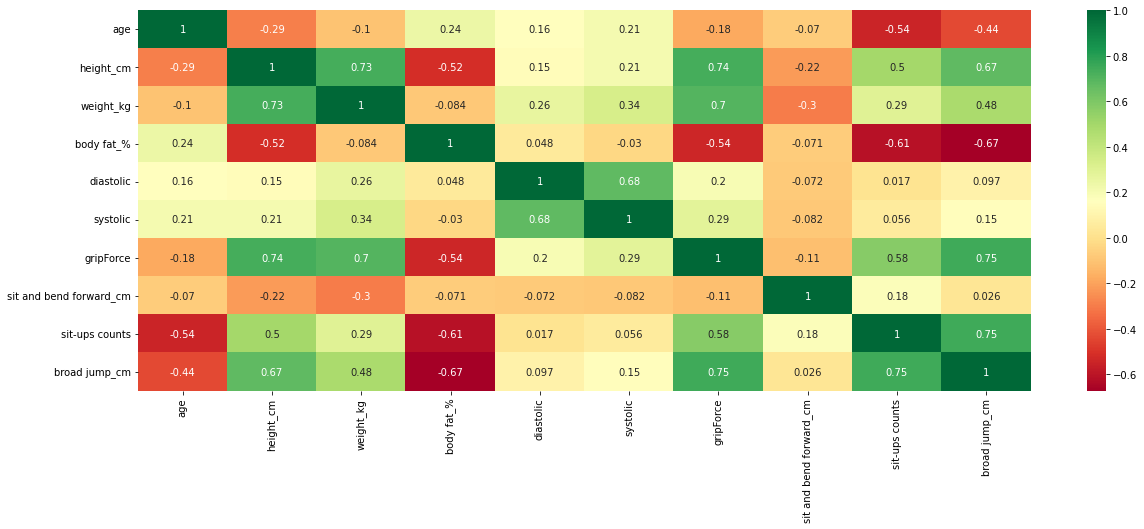

In [50]:
df = pd.read_csv("/content/data/Multiclass_Classification/body_Performance.csv")

plt.figure(figsize=(20,7))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')





> According to the graph above, there is no multicollinearity in each variables.





* **In the multivariate models are predictor variables independent of all the other predictor variables?**









> Yes, all independent variables are indenpendent.



* **In multivariate models, rank the most significant predictor variables and exclude insignificant ones from the model.**

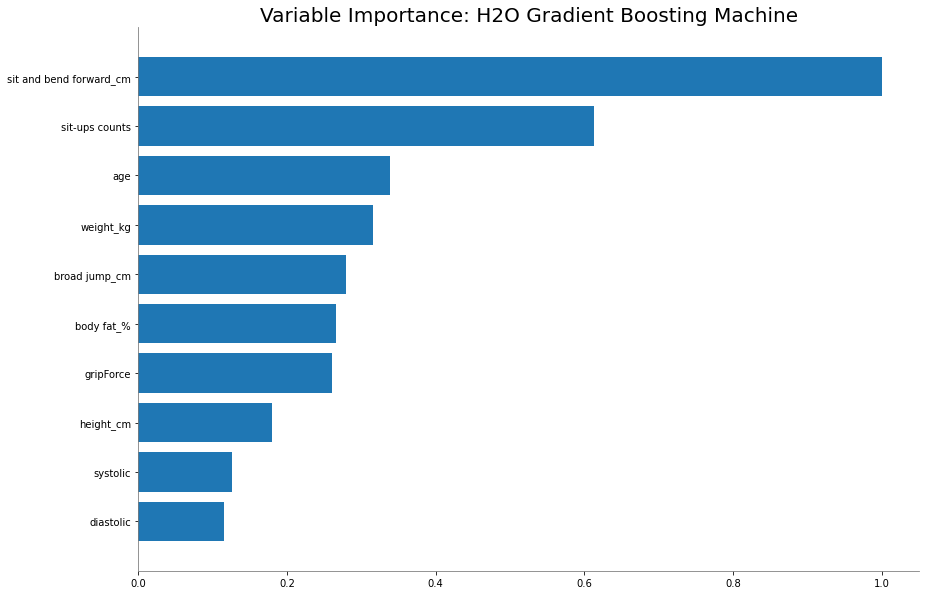

<Figure size 432x288 with 0 Axes>

In [51]:
%matplotlib inline
best_model.varimp_plot()

The most insignificant variable is "diastolic", so I remove it and reform AutoML model.

In [52]:
X.remove("diastolic")

# Rerun AutoML
aml = H2OAutoML(max_models = 10, seed = 1)
aml.train(x = X, y = Y, training_frame = train)

lb = aml.leaderboard
lb.head()

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_AllModels_1_AutoML_7_20221108_61609,0.255947,0.627895,0.459073,0.210748
StackedEnsemble_BestOfFamily_1_AutoML_7_20221108_61609,0.257728,0.631041,0.460023,0.211621
GBM_2_AutoML_7_20221108_61609,0.261614,0.649613,0.469539,0.220467
GBM_3_AutoML_7_20221108_61609,0.264596,0.649054,0.467184,0.218261
GBM_4_AutoML_7_20221108_61609,0.266377,0.652786,0.466186,0.217329
XGBoost_3_AutoML_7_20221108_61609,0.266387,0.653579,0.469155,0.220106
GBM_1_AutoML_7_20221108_61609,0.268584,0.651471,0.469118,0.220072
DRF_1_AutoML_7_20221108_61609,0.27314,0.75327,0.492129,0.242191
XRT_1_AutoML_7_20221108_61609,0.273934,0.748682,0.496608,0.246619
XGBoost_2_AutoML_7_20221108_61609,0.276732,0.677711,0.472021,0.222804


In [53]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = se.metalearner()

metalearner.coef_norm()

{'std_coefs_class_A': {'Intercept': -5.805903015058636,
  'GBM_2_AutoML_7_20221108_61609/A': 0.36176099609633255,
  'GBM_2_AutoML_7_20221108_61609/B': 0.0,
  'GBM_2_AutoML_7_20221108_61609/C': 0.0,
  'GBM_2_AutoML_7_20221108_61609/D': 0.0,
  'GBM_3_AutoML_7_20221108_61609/A': 0.0805335261721591,
  'GBM_3_AutoML_7_20221108_61609/B': 0.0,
  'GBM_3_AutoML_7_20221108_61609/C': 0.0,
  'GBM_3_AutoML_7_20221108_61609/D': 0.0,
  'GBM_4_AutoML_7_20221108_61609/A': 0.5255486672981995,
  'GBM_4_AutoML_7_20221108_61609/B': 0.2968011093467262,
  'GBM_4_AutoML_7_20221108_61609/C': 0.0,
  'GBM_4_AutoML_7_20221108_61609/D': 0.0,
  'XGBoost_3_AutoML_7_20221108_61609/A': 1.0657499044230574,
  'XGBoost_3_AutoML_7_20221108_61609/B': 0.16371539639039548,
  'XGBoost_3_AutoML_7_20221108_61609/C': 0.0,
  'XGBoost_3_AutoML_7_20221108_61609/D': -0.3612152114040393,
  'GBM_1_AutoML_7_20221108_61609/A': 0.659259827264207,
  'GBM_1_AutoML_7_20221108_61609/B': 0.46037285417622575,
  'GBM_1_AutoML_7_20221108_61609/C

In [55]:
# Showing prediction of the best model in AutoML
best_model = h2o.get_model("GBM_2_AutoML_7_20221108_61609")
performance = best_model.model_performance(test)
performance.confusion_matrix()

A,B,C,D,Error,Rate
722.0,105.0,6.0,3.0,0.1363636,114 / 836
179.0,518.0,115.0,26.0,0.3818616,320 / 838
57.0,181.0,559.0,32.0,0.3256936,270 / 829
8.0,43.0,89.0,671.0,0.1726264,140 / 811
966.0,847.0,769.0,732.0,0.2546771,"844 / 3,314"




> The result shows that "diastolic" doesn't affect the model.



* **Does the model make sense?**



> According to the result from the model, the level of body health related closely with "sit and bend forward_cm", "sit-ups count" and other physical index, and this matches the real life.



* **Does regularization help?**



> Multiclass classification doesn't need to use regularization.



* **Which independent variables are significant?**



> People's sit and bend forward_cm.



* **Which hyperparameters are important?**



> I didn't use any hyperparameters in this multiclass classification's model learning process.



## *Citation*:

aiskunks. “Automl_binary_classification_product_backorders.Ipynb.” Github, 31 Oct. 2022, https://github.com/aiskunks/Skunks_Skool/blob/main/H2O_AutoML_IPYNB/automl_binary_classification_product_backorders.ipynb.

aiskunks. “Automl_regression_powerplant_output.Ipynb.” Github, 31 Oct. 2022, https://github.com/aiskunks/Skunks_Skool/blob/main/H2O_AutoML_IPYNB/automl_regression_powerplant_output.ipynb.

H2O.ai. “AutoML: Automatic Machine Learning.” H2O.Ai, https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html#training.